Cite https://colab.research.google.com/github/dair-ai/notebooks/blob/master/_notebooks/2020-03-18-pytorch_quick_start.ipynb

In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

seed = 8888

print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  8888


In [2]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Number of workers for dataloader
workers = 2
batch_size = 128

# All images will be resized to this
image_size = 64
input_size = 100

num_epochs = 50
ngpu = 1

In [4]:
import torchvision.datasets as datasets
mnist_train = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]),
                           download=True)

dataloader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


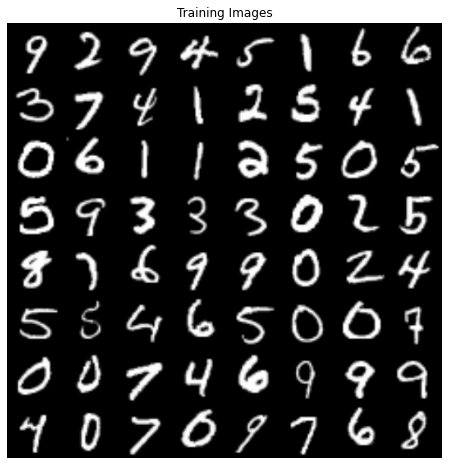

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

DCGAN Models

In [7]:
# Used to initialize weights for conv2d and batch norm layers
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input (100, 1, 1)
            nn.ConvTranspose2d( nz, 32 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(32 * 8, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( 32 * 4, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( 32 * 2, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d( 32, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 32 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32 * 2, 32 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32 * 4, 32 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
gan_generator = Generator(ngpu).to(device)

# Randomly initialize all weights, mean=0, stdev=0.2
gan_generator.apply(weights_init)

print(gan_generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Create the Discriminator
gan_discriminator = Discriminator(ngpu).to(device)

# Randomly initialize all weights, mean=0, stdev=0.2
gan_discriminator.apply(weights_init)

print(gan_discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Training

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# This batch of latent vectors are used to test the generator during training
fixed_noise = torch.randn(64, input_size, 1, 1, device=device)

# Setup Adam optimizers for both G and D
beta_adam = 0.5
lr = 0.0002
optimizerD = optim.Adam(gan_discriminator.parameters(), lr=lr, betas=(beta_adam, 0.999))
optimizerG = optim.Adam(gan_generator.parameters(), lr=lr, betas=(beta_adam, 0.999))

In [12]:
# Training Loop

img_list = []
G_losses = []
D_losses = []
iters = 0
real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        gan_discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((real_cpu.size(0),), real_label, device=device)

        # Forward pass real batch through D, we will train D on both real and fake data
        output = gan_discriminator(real_cpu).view(-1)
        # print(gan_discriminator(real_cpu).shape)
        errD_real = criterion(output, label.float())
        errD_real.backward()

        # Train with fake batch
        noise = torch.randn(real_cpu.size(0), input_size, 1, 1, device=device)
        fake = gan_generator(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = gan_discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update generator with log(D(G(z)))
        gan_generator.zero_grad()
        label.fill_(real_label)
        
        output = gan_discriminator(fake).view(-1)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gan_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/469]	Loss_D: 1.4111	Loss_G: 1.5993	D(x): 0.4848	D(G(z)): 0.4440 / 0.2253
[1/50][0/469]	Loss_D: 0.1153	Loss_G: 4.1290	D(x): 0.9700	D(G(z)): 0.0787 / 0.0217
[2/50][0/469]	Loss_D: 0.6268	Loss_G: 2.0403	D(x): 0.6055	D(G(z)): 0.0255 / 0.1695
[3/50][0/469]	Loss_D: 0.1734	Loss_G: 4.0396	D(x): 0.9700	D(G(z)): 0.1246 / 0.0254
[4/50][0/469]	Loss_D: 0.4878	Loss_G: 2.4270	D(x): 0.7910	D(G(z)): 0.1964 / 0.1176
[5/50][0/469]	Loss_D: 0.0736	Loss_G: 3.5472	D(x): 0.9437	D(G(z)): 0.0134 / 0.0441
[6/50][0/469]	Loss_D: 0.0669	Loss_G: 5.7621	D(x): 0.9918	D(G(z)): 0.0550 / 0.0053
[7/50][0/469]	Loss_D: 0.4568	Loss_G: 1.8850	D(x): 0.7608	D(G(z)): 0.1335 / 0.2061
[8/50][0/469]	Loss_D: 0.5984	Loss_G: 1.6418	D(x): 0.6841	D(G(z)): 0.1590 / 0.2326
[9/50][0/469]	Loss_D: 0.5511	Loss_G: 5.9208	D(x): 0.9800	D(G(z)): 0.3753 / 0.0039
[10/50][0/469]	Loss_D: 0.3261	Loss_G: 3.2305	D(x): 0.7805	D(G(z)): 0.0369 / 0.0733
[11/50][0/469]	Loss_D: 0.6493	Loss_G: 2.2420	D(x): 0.8657	D(G(z)): 0.35

In [13]:
torch.save(gan_generator.state_dict(), 'generator.pth')
torch.save(gan_discriminator.state_dict(), 'discriminator.pth')

In [14]:
gan_generator = Generator(ngpu).to(device)
gan_generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

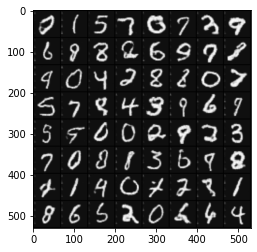

In [15]:
with torch.no_grad():
    fake = gan_generator(fixed_noise).detach().cpu()
 
show = vutils.make_grid(fake, padding=2, normalize=True)
plt.imshow(np.transpose(show,(1,2,0)))

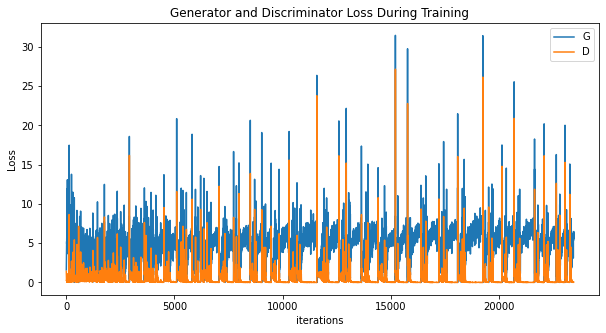

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

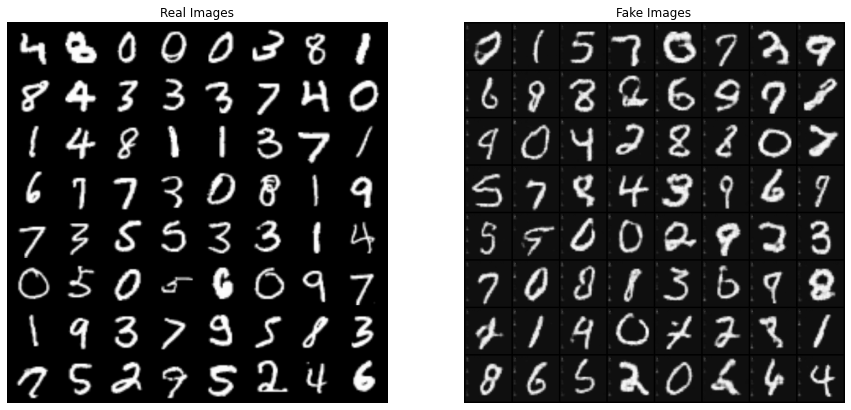

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()